<a href="https://colab.research.google.com/github/Nithika0070/depth_prediction_transformer/blob/main/DPTForDepthEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data download
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bvighnesh27/exaggerated-synthetic-corneal-data")

print("Path to dataset files:", path)

100%|██████████| 1.89G/1.89G [01:31<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bvighnesh27/exaggerated-synthetic-corneal-data/versions/1


In [2]:
# Recommended minimal installs for this notebook
!pip install -q transformers==4.40.0  # pick an LTS-compatible version
!pip install -q datasets
!pip install -q timm      # Optional: alternate backbones if needed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.


In [3]:
import os, glob, re, math, time, json, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import AutoImageProcessor, DPTForDepthEstimation
# AutoImageProcessor works for DPT image preprocessing

In [4]:
# ---------- Utility to pair images and csvs ----------
def _numeric_key(path):
    match = re.search(r"\d+", Path(path).stem)
    return match.group(0) if match else None

def find_pairs(image_dir, csv_dir, image_exts=("png","jpg","jpeg")):
    images = []
    for ext in image_exts:
        images += glob.glob(os.path.join(image_dir, f"**/*.{ext}"), recursive=True)
    csvs = glob.glob(os.path.join(csv_dir, "**/*.csv"), recursive=True)

    csv_map = {_numeric_key(p): p for p in csvs if _numeric_key(p)}
    print("CSV numeric keys found:", csv_map.keys()) # Added for debugging
    pairs = []
    for img in images:
        key = _numeric_key(img)
        if key and key in csv_map:
            pairs.append((img, csv_map[key]))
        else:
            print(f"[WARN] No matching csv found for {img}, skipping")
    pairs = sorted(pairs)
    return pairs

# ---------- Dataset ----------
class CorneaDataset(Dataset):
    """
    Returns (image_tensor, target_tensor)
    target_tensor shape: (n_points*3,) flattened [x1,y1,z1, x2,y2,z2, ...]
    """
    def __init__(self, pairs, image_processor=None, image_size=384, augment=False):
        self.pairs = pairs
        self.processor = image_processor
        self.image_size = image_size
        self.augment = augment
        if len(self.pairs)==0:
            raise ValueError("No (image,csv) pairs provided.")
        # determine n_points (expect consistent across CSVs)
        self._n_points = None
        for _, csv_path in pairs:
            df = pd.read_csv(csv_path)
            if df.shape[1] < 3:
                raise ValueError(f"CSV {csv_path} must have at least 3 columns")
            rows = len(df)
            if self._n_points is None:
                self._n_points = rows
            elif self._n_points != rows:
                raise ValueError(f"Inconsistent points: {csv_path} has {rows} but expected {self._n_points}")
        self.target_dim = self._n_points * 3

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, csv_path = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        # use transformer processor if provided (keeps same logic as DPT)
        if self.processor is not None:
            proc = self.processor(images=image, return_tensors="pt")
            # proc contains pixel_values: shape (1, 3, H, W)
            img_tensor = proc["pixel_values"].squeeze(0)
        else:
            # fallback torchvision transforms
            img_tensor = F.interpolate(torch.from_numpy(np.array(image).astype(np.float32)/255.0).permute(2,0,1).unsqueeze(0),
                                       size=(self.image_size, self.image_size)).squeeze(0)

        # read CSV target
        df = pd.read_csv(csv_path)
        # find columns by name or fallback to first three
        cols = df.columns.tolist()
        if set(["x","y","z"]).issubset(set(cols)):
            arr = df[["x","y","z"]].values
        else:
            arr = df.iloc[:, :3].values
        target = torch.tensor(arr.reshape(-1), dtype=torch.float32)  # (n_points*3,)
        return img_tensor, target

# ---------- prepare dataloaders ----------
def prepare_dataloaders(image_dir, csv_dir, image_processor, batch_size=8, image_size=384,
                        train_frac=0.8, seed=42, num_workers=0):
    pairs = find_pairs(image_dir, csv_dir)
    if len(pairs)==0:
        raise ValueError("No pairs found. Check directories.")
    random.Random(seed).shuffle(pairs)
    n_train = int(len(pairs) * train_frac)
    train_pairs = pairs[:n_train]
    val_pairs = pairs[n_train:]

    train_ds = CorneaDataset(train_pairs, image_processor=image_processor, image_size=image_size)
    val_ds = CorneaDataset(val_pairs, image_processor=image_processor, image_size=image_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    info = {
        "n_points": train_ds._n_points,
        "target_dim": train_ds.target_dim,
        "n_train": len(train_ds),
        "n_val": len(val_ds),
        "pairs_all": pairs
    }
    return train_loader, val_loader, info

In [5]:
IMAGE_DIR = os.path.join(path, "corneal_side", "corneal_side")
CSV_DIR   = os.path.join(path, "data", "data")
# Use DPT's processor to prepare pixel values
processor = AutoImageProcessor.from_pretrained("Intel/dpt-large")
train_loader, val_loader, info = prepare_dataloaders(IMAGE_DIR, CSV_DIR, processor, batch_size=8, image_size=384)
print(info)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


CSV numeric keys found: dict_keys(['059', '478', '095', '136', '468', '242', '262', '160', '189', '142', '172', '388', '259', '158', '062', '147', '296', '248', '295', '026', '192', '092', '230', '398', '307', '003', '311', '441', '404', '470', '469', '328', '053', '277', '076', '186', '366', '040', '058', '333', '403', '341', '021', '082', '030', '025', '413', '306', '487', '498', '439', '353', '086', '480', '091', '148', '217', '233', '378', '344', '119', '249', '337', '028', '141', '014', '484', '036', '361', '411', '243', '362', '176', '167', '457', '034', '476', '187', '157', '312', '461', '490', '067', '462', '016', '052', '001', '078', '294', '445', '113', '068', '321', '297', '199', '035', '471', '089', '074', '437', '057', '117', '481', '214', '436', '274', '452', '191', '313', '126', '449', '170', '134', '252', '287', '098', '108', '280', '060', '129', '122', '165', '173', '031', '354', '127', '177', '080', '203', '339', '132', '055', '054', '350', '275', '261', '395', '359',

In [6]:
# List the contents of the image and data directories to help identify the correct paths
print("Contents of IMAGE_DIR:")
!ls -R "$IMAGE_DIR"

print("\nContents of CSV_DIR:")
!ls -R "$CSV_DIR"

Contents of IMAGE_DIR:
/root/.cache/kagglehub/datasets/bvighnesh27/exaggerated-synthetic-corneal-data/versions/1/corneal_side/corneal_side:
cornea_side_001.png  cornea_side_168.png  cornea_side_335.png
cornea_side_002.png  cornea_side_169.png  cornea_side_336.png
cornea_side_003.png  cornea_side_170.png  cornea_side_337.png
cornea_side_004.png  cornea_side_171.png  cornea_side_338.png
cornea_side_005.png  cornea_side_172.png  cornea_side_339.png
cornea_side_006.png  cornea_side_173.png  cornea_side_340.png
cornea_side_007.png  cornea_side_174.png  cornea_side_341.png
cornea_side_008.png  cornea_side_175.png  cornea_side_342.png
cornea_side_009.png  cornea_side_176.png  cornea_side_343.png
cornea_side_010.png  cornea_side_177.png  cornea_side_344.png
cornea_side_011.png  cornea_side_178.png  cornea_side_345.png
cornea_side_012.png  cornea_side_179.png  cornea_side_346.png
cornea_side_013.png  cornea_side_180.png  cornea_side_347.png
cornea_side_014.png  cornea_side_181.png  cornea_side_

In [7]:
class DPTRegressor(nn.Module):
    def __init__(self, dpt_model_name="Intel/dpt-hybrid", target_dim=None, pool_mode="avg"):
        """
        dpt_model_name: HF model checkpoint
        target_dim: n_points * 3 (required)
        pool_mode: 'avg' or 'flatten' (avg pooling reduces dim before MLP)
        """
        super().__init__()
        assert target_dim is not None, "target_dim needed"
        self.dpt = DPTForDepthEstimation.from_pretrained(dpt_model_name)
        # DPT's predicted_depth shape is (B, H, W). We'll add channel dim
        self.pool_mode = pool_mode

        # compute flattened feature dimension after pooling:
        # if pool_mode == 'avg' -> use global avg pooled features dim = 1
        # We'll instead use small adaptive pooling to preserve some spatial info
        self.adaptive_pool = nn.AdaptiveAvgPool2d((16,16))  # tuneable
        pooled_dim = 16*16  # per channel (we'll expand to 1 channel)

        mlp_input_dim = pooled_dim
        # MLP: output target_dim
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(mlp_input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, target_dim)
        )

    def forward(self, pixel_values):
        """
        pixel_values: (B, 3, H, W) preprocessed by the AutoImageProcessor
        returns: (B, target_dim)
        """
        # Use DPT to produce predicted_depth (the usual forward)
        # DPT returns outputs.predicted_depth shape (B, H, W)
        outputs = self.dpt(pixel_values=pixel_values)
        # predicted_depth shape (B, H, W) -> add channel dim
        depth = outputs.predicted_depth.unsqueeze(1)  # (B,1,H,W)

        # Adaptive pool to (B,1,16,16)
        p = self.adaptive_pool(depth)   # (B,1,16,16)
        x = p  # keep single channel
        # Flatten & MLP
        out = self.mlp(x)
        return out

In [8]:
import sklearn.metrics as skm

def train_fit(model, train_loader, val_loader, info, device,
              epochs=10, lr=3e-4, weight_decay=1e-2, ckpt_path="/content/best_vit_decoder.pth"):
    target_dim = info["target_dim"]
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best_val = float("inf")

    history = {"train_loss":[], "val_loss":[], "train_mae":[], "val_mae":[], "train_r2":[], "val_r2":[]}

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        preds_all = []
        trues_all = []
        for imgs, targets in tqdm(train_loader, desc=f"Train E{epoch}"):
            imgs = imgs.to(device)
            targets = targets.to(device)  # (B, target_dim)
            optimizer.zero_grad()
            out = model(imgs)             # (B, target_dim)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            preds_all.append(out.detach().cpu().numpy())
            trues_all.append(targets.detach().cpu().numpy())

        # aggregate train metrics
        preds_np = np.concatenate(preds_all, axis=0)
        trues_np = np.concatenate(trues_all, axis=0)
        train_mse = np.mean(train_losses)
        train_mae = skm.mean_absolute_error(trues_np, preds_np)
        try:
            train_r2 = skm.r2_score(trues_np, preds_np)
        except:
            train_r2 = float("nan")

        # validation
        model.eval()
        val_losses = []
        preds_all = []
        trues_all = []
        with torch.no_grad():
            for imgs, targets in tqdm(val_loader, desc=f"Val E{epoch}"):
                imgs = imgs.to(device)
                targets = targets.to(device)
                out = model(imgs)
                loss = criterion(out, targets)
                val_losses.append(loss.item())
                preds_all.append(out.cpu().numpy())
                trues_all.append(targets.cpu().numpy())

        preds_np = np.concatenate(preds_all, axis=0)
        trues_np = np.concatenate(trues_all, axis=0)
        val_mse = np.mean(val_losses)
        val_mae = skm.mean_absolute_error(trues_np, preds_np)
        try:
            val_r2 = skm.r2_score(trues_np, preds_np)
        except:
            val_r2 = float("nan")

        print(f"[Epoch {epoch}] Train MSE={train_mse:.5f} MAE={train_mae:.5f} R2={train_r2:.4f} | Val MSE={val_mse:.5f} MAE={val_mae:.5f} R2={val_r2:.4f}")
        history["train_loss"].append(train_mse)
        history["val_loss"].append(val_mse)
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)
        history["train_r2"].append(train_r2)
        history["val_r2"].append(val_r2)

        scheduler.step()
        if val_mse < best_val:
            best_val = val_mse
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_mse,
                "info": info
            }, ckpt_path)
            print(f"[Checkpoint] saved {ckpt_path} val_mse={val_mse:.5f}")

    return history


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_dim = info["target_dim"]
model = DPTRegressor(dpt_model_name="Intel/dpt-large", target_dim=target_dim).to(device)

# Optionally freeze DPT backbone initially to train only the head:
for p in model.dpt.parameters():
    p.requires_grad = False
# unfreeze head already trainable

history = train_fit(model, train_loader, val_loader, info, device,
                    epochs=10, lr=3e-4, weight_decay=1e-2, ckpt_path="/content/best_dpt_cornea.pth")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train E1:   0%|          | 0/50 [00:00<?, ?it/s]

Val E1:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 1] Train MSE=0.53725 MAE=0.52061 R2=-70482719724797952.0000 | Val MSE=0.19997 MAE=0.32823 R2=-866609040195584.0000
[Checkpoint] saved /content/best_dpt_cornea.pth val_mse=0.19997


Train E2:   0%|          | 0/50 [00:00<?, ?it/s]

Val E2:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 2] Train MSE=0.11483 MAE=0.24922 R2=-9903412900528128.0000 | Val MSE=0.01316 MAE=0.07735 R2=-79621252972544.0000
[Checkpoint] saved /content/best_dpt_cornea.pth val_mse=0.01316


Train E3:   0%|          | 0/50 [00:00<?, ?it/s]

Val E3:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 3] Train MSE=0.03773 MAE=0.14628 R2=-5429530151878656.0000 | Val MSE=0.00152 MAE=0.02782 R2=-23895054745600.0000
[Checkpoint] saved /content/best_dpt_cornea.pth val_mse=0.00152


Train E4:   0%|          | 0/50 [00:00<?, ?it/s]

Val E4:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 4] Train MSE=0.02673 MAE=0.12045 R2=-2392745876389888.0000 | Val MSE=0.00075 MAE=0.02050 R2=-13372967878656.0000
[Checkpoint] saved /content/best_dpt_cornea.pth val_mse=0.00075


Train E5:   0%|          | 0/50 [00:00<?, ?it/s]

Val E5:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 5] Train MSE=0.02060 MAE=0.10409 R2=-1630047328796672.0000 | Val MSE=0.00335 MAE=0.04533 R2=-2815377539072.0000


Train E6:   0%|          | 0/50 [00:00<?, ?it/s]

Val E6:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 6] Train MSE=0.01868 MAE=0.09788 R2=-1286695697776640.0000 | Val MSE=0.00083 MAE=0.02125 R2=-3879752695808.0000


Train E7:   0%|          | 0/50 [00:00<?, ?it/s]

Val E7:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 7] Train MSE=0.01833 MAE=0.09458 R2=-878856139440128.0000 | Val MSE=0.00040 MAE=0.01371 R2=-2313533259776.0000
[Checkpoint] saved /content/best_dpt_cornea.pth val_mse=0.00040


Train E8:   0%|          | 0/50 [00:00<?, ?it/s]

Val E8:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 8] Train MSE=0.01506 MAE=0.08644 R2=-808642886500352.0000 | Val MSE=0.00223 MAE=0.03730 R2=-1567658082304.0000


Train E9:   0%|          | 0/50 [00:00<?, ?it/s]

Val E9:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 9] Train MSE=0.01611 MAE=0.08795 R2=-734846355767296.0000 | Val MSE=0.00044 MAE=0.01508 R2=-770781937664.0000


Train E10:   0%|          | 0/50 [00:00<?, ?it/s]

Val E10:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 10] Train MSE=0.01493 MAE=0.08509 R2=-722165666152448.0000 | Val MSE=0.00101 MAE=0.02502 R2=-227764912128.0000


In [11]:
def infer_and_save(model, dataloader, info, device, out_csv="/content/predictions.csv"):
    model.eval()
    rows = []
    pairs = dataloader.dataset.pairs  # (img_path, csv_path)
    with torch.no_grad():
        for i, (imgs, targets) in enumerate(tqdm(dataloader, desc="Infer")):
            imgs = imgs.to(device)
            outs = model(imgs)  # (B, target_dim)
            outs_np = outs.cpu().numpy()
            targets_np = targets.numpy()
            batch_size = outs_np.shape[0]
            for b in range(batch_size):
                img_path, csv_path = pairs[i * dataloader.batch_size + b]
                # reshape predicted values back to Nx3 for convenience
                n_points = info["n_points"]
                pred_flat = outs_np[b]
                pred_points = pred_flat.reshape(n_points, 3)
                # flatten to a string or store columns
                row = {
                    "image": os.path.basename(img_path),
                    "csv": os.path.basename(csv_path),
                    "pred_flat": json.dumps(pred_flat.tolist())
                }
                rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print("Saved predictions to", out_csv)

# Example usage:
model_ckpt = torch.load("/content/best_dpt_cornea.pth", map_location=device, weights_only=False)
model.load_state_dict(model_ckpt["model_state_dict"])
infer_and_save(model, val_loader, info, device=device, out_csv="/content/predictions_val.csv")

Infer:   0%|          | 0/13 [00:00<?, ?it/s]

Saved predictions to /content/predictions_val.csv


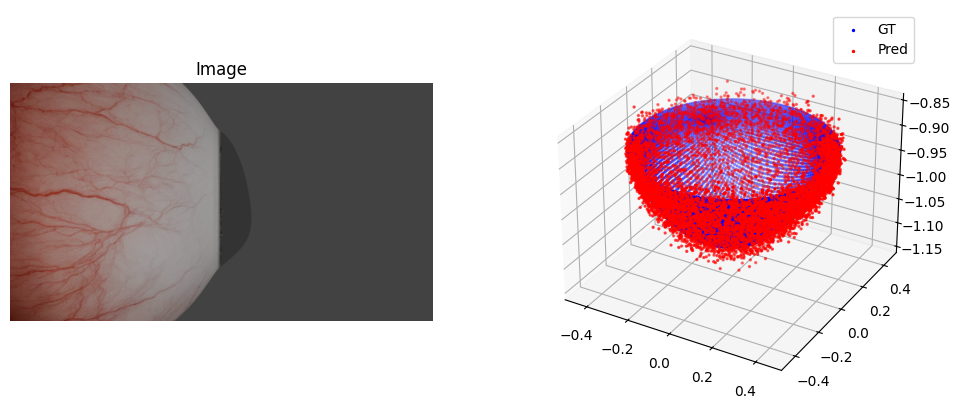

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def plot_gt_vs_pred(image_path, gt_csv, pred_flat):
    # load image
    img = Image.open(image_path).convert("RGB")
    gt = pd.read_csv(gt_csv)
    # get points Nx3
    if set(["x","y","z"]).issubset(set(gt.columns)):
        gt_points = gt[["x","y","z"]].values
    else:
        gt_points = gt.iloc[:,:3].values
    pred_points = np.array(pred_flat).reshape(-1,3)

    fig = plt.figure(figsize=(12,5))
    ax0 = fig.add_subplot(121)
    ax0.imshow(img); ax0.axis("off"); ax0.set_title("Image")
    ax1 = fig.add_subplot(122, projection='3d')
    ax1.scatter(gt_points[:,0], gt_points[:,1], gt_points[:,2], s=2, c='blue', label='GT')
    ax1.scatter(pred_points[:,0], pred_points[:,1], pred_points[:,2], s=2, c='red', label='Pred')
    ax1.legend()
    plt.show()

# Example: pick first val sample
img_path, csv_path = val_loader.dataset.pairs[0]
# load pred from saved csv or infer on the fly:
with torch.no_grad():
    img_tensor, target = val_loader.dataset[0]
    pred_flat = model(img_tensor.unsqueeze(0).to(device)).cpu().numpy().squeeze()
plot_gt_vs_pred(img_path, csv_path, pred_flat)


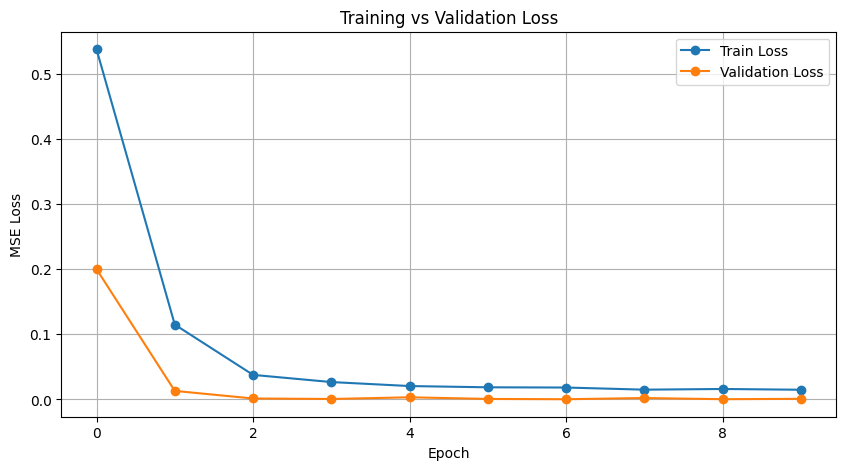

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()
